In [51]:
import pytraj as pt
import pytraj.utils.progress
import numpy as np
import scipy as sp
from scipy import signal
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt
import collections
import sys
import gc
import os
import sklearn as skl
from sklearn import decomposition
from sklearn import metrics
from sklearn import discriminant_analysis
from sklearn import pipeline
import tqdm
import nglview as nv
import ipywidgets
from ipywidgets import interact, interactive
import copy
import cPickle
import bokeh
from bokeh import io, plotting
from bokeh.palettes import brewer

# Preamble
This notebook will look into analyzing the effect of modulating
the lipid environment upon piezo's conformational dynamics.

There are some important differences to consider here.

First and foremost, whereas the ligand simulations affect piezo's
by directly perturbing the structure of a particular arm, these
simulations instead modulate the membrane environment surrounding piezo.

Piezo is a triskelion shaped homo-trimer. Its cryo-em structure is quite
symmetric.... however, this symmetry is not retained during simulation.

Interestingly, observing the structure of Piezo under several replicas in
symmetric, single component membrane environment reveal that one arm will
always display different conformations compared to the other arms.

The arm which does so is not the same from one replica to the next, so it
seems that this breaking of symmetry is just a consequence of acclimating
to a higher temperature membrane environment (315 K here as compared to
around 90K for cryo em).

So... over many replicas, we seem to recover the symmetry as an average
property...

Unfortunately, running many replicas is not tractable for this system due to its
sheer size... Instead, we will consider measurements from different arms as equivalent.

This was not done for the ligand simulations, however, because, as mentioned, one particular arm
was being perturbed. Thus tracking which individual arm each measurement came from was important
during analysis of ligand simulations, but here, we are able to consider average
properties over all 3 arms.

This will incur a little legwork in the initial setup but should prove helpful
during subsequent analysis because, after inducing symmetry, we will have one third as many
features to consider.

# Data Loading and Formatting

We will now begin by loading the joint simulation data and transforming to treat
measurements from each arm as equivalent. This will be done by first melting the
data frame. We can then operate on the angle labels column reassign the
residue index number as $resid_{new}=resid_{old}\bmod3$ (i.e. take the remainder
after dividing by 3). A new column can them be added track which arm each angle
belonged to. The data will then be repivoted for further analysis.

This next section performs this cleaning. The cleaned version should already be
present in the github archive.
If you want to skip this initial cleaning then run the next cell, which defines 
the piecewise data frame loading routine, and then skip to the analysis section
and run the loading cell there.

Loading and munging the extracted phi-psi data takes about 45 minutes to one hour of 
processing time on my 2019 iMac. Since the final cleaned version is already 
present in the archive, you could skip this if you want to save some time.

## Raw Extracted Phi-Psi Data loading 
As usual, we had to save the data table in chunks. We thus need to define an appropriate
loading function as shown below

In [2]:
def loadDataFrameChunks(filePathBase,nChunks):
    dataTables=[]
    chunkStr='chunk_%s0%gg'%('%',int(np.floor(np.log10(nChunks)))+1)
    with tqdm.tqdm_notebook(np.arange(nChunks)) as loadBar:
        loadBar.set_description('Loading Data Frame Chunks')
        for iChunk in loadBar:
            dataFilePath='.'.join([filePathBase,chunkStr%iChunk,'csv'])
            dataTables.append(
                pd.read_csv(dataFilePath))
            gc.collect()
    return pd.concat(dataTables)

If you want to run through the data munging section, continue to the cell below,
otherwise, skip to the analysis section
Lets check how many chunks we have

In [3]:
!ls -l dataFiles/phiPsiTables/joint_memb.phi_psi_table.chunk_*.csv | awk -F / '{print $NF}' | awk -F . '{print $(NF-1)}' | awk -F _ '{print $NF}' | tail -n 1

41


In [4]:
rawPhiPsiTable=loadDataFrameChunks('dataFiles/phiPsiTables/joint_memb.phi_psi_table',nChunks=41)
rawPhiPsiTable.head()

,System,Frame,psi_1,phi_2,psi_2,phi_3,psi_3,phi_4,psi_4,phi_5,...,psi_4249,phi_4250,psi_4250,phi_4251,psi_4251,phi_4252,psi_4252,phi_4253,psi_4253,phi_4254
0,POPC,0,-92.538319,-90.675970,50.467890,-83.536252,-56.646704,-66.994656,-43.655675,-48.537961,...,-45.001072,-51.833152,-49.188380,-81.741315,-5.315496,-82.160726,-80.366564,-54.248897,-57.795869,-103.283576
1,POPC,1,-67.897299,-87.968510,80.827211,-84.977793,-53.473650,-67.267185,-21.730216,-73.346152,...,-57.252846,-47.089584,-56.609321,-51.742248,-42.113380,-67.250609,-62.100206,-79.930780,-63.703503,-88.860026
2,POPC,2,-54.649079,-77.358751,105.068599,-86.017091,-75.500165,-66.551154,-40.604271,-70.945980,...,-39.616951,-51.222322,-59.783692,-64.687987,-25.811014,-81.296024,-35.502232,-90.227413,-45.320649,-101.483824
3,POPC,3,-53.227823,-62.547584,65.871080,-69.612892,-49.677393,-56.152612,-45.944265,-70.275168,...,-58.491646,-41.057612,-45.783047,-73.580293,-48.073389,-60.708680,-52.913657,-78.880614,-48.355414,-108.382543
4,POPC,4,-44.386791,-75.632470,78.984520,-65.249080,-56.598326,-44.975400,-44.357276,-76.498243,...,-55.192075,-52.667300,-42.970486,-76.748131,-51.178906,-55.404238,-48.370952,-87.449109,-52.053732,-104.899646


### Data munging
We now need to transform our data as detailed above

#### Melt to long form

In [5]:
phiPsiTableLong=pd.melt(frame=rawPhiPsiTable,
                        id_vars=['System','Frame'],
                        var_name='Angle',
                        value_name='Measurement')
phiPsiTableLong.head()

,System,Frame,Angle,Measurement
0,POPC,0,psi_1,-92.538319
1,POPC,1,psi_1,-67.897299
2,POPC,2,psi_1,-54.649079
3,POPC,3,psi_1,-53.227823
4,POPC,4,psi_1,-44.386791


#### Transform Angle labels
As discussed, we need to transform the data so that each arm has
its own row. So we end up with $nResPerArm$ columns instead of
the previous $nArms\times nResPerArm$ columns previously.
We will add an 'Arm' column to keep track of which arm each entry
came from (although we wont really use this in our initial analysis here,
it may be useful in the future)

In this case, that means each frame will be split into 3 rows with
1418 columns instead of the previous single row with 4254 columns

In [6]:
nRes=4254 #total number of residues
nArms=3 #total number of arms
nResPerArm=nRes/nArms #number of residues in one arm
tqdm.tqdm_notebook().pandas()
#Split 'Angle' column
#Add 'Angle Type' column by splitting 'Angle' on '_' and taking first entry
phiPsiTableLong['AngleType']=phiPsiTableLong['Angle'].progress_apply(
    lambda x: x.split('_')[0])
#Add 'ResID' column by splitting 'Angle' on '_' and taking second entry
phiPsiTableLong['ResID']=phiPsiTableLong['Angle'].progress_apply(
    lambda x: x.split('_')[1])
#Add 'ResNum' column as ResID%nResPerArm
#Ensuring that the result is a series of integers seems to take a bit of finesse
phiPsiTableLong['ResNum']=pd.Series(
        pd.Series(
            phiPsiTableLong['ResID'],
            dtype=float
        ),dtype=int
    ).progress_apply(
        lambda x: int(np.floor(x-1)%nResPerArm)+1)
#Add 'Arm' column as floor(ResID/nResPerArm)
phiPsiTableLong['Arm']=pd.Series(
        pd.Series(
            phiPsiTableLong['ResID'],
            dtype=float
        ),dtype=int
    ).progress_apply(
        lambda x: 'Arm_%g'%(int((x-1)/nResPerArm)+1))
#Re-form angle column by merging ResNum and AngleType
phiPsiTableLong['Angle']=phiPsiTableLong[['AngleType','ResNum']].progress_apply(
    lambda x: '%s_%g'%(x[0],int(x[1])),axis=1)
#Remove unused columns
phiPsiTableLong=phiPsiTableLong[
    ['System','Frame','Arm','Angle','Measurement']]
phiPsiTableLong.head()

,System,Frame,Arm,Angle,Measurement
0,POPC,0,Arm_1,psi_1,-92.538319
1,POPC,1,Arm_1,psi_1,-67.897299
2,POPC,2,Arm_1,psi_1,-54.649079
3,POPC,3,Arm_1,psi_1,-53.227823
4,POPC,4,Arm_1,psi_1,-44.386791


In [19]:
#One problem... when we pivot back, our angles will get orderd
#strangely.
phiPsiTableLong['Angle']=phiPsiTableLong['Angle'].progress_apply(
    lambda x: '%s_%04g'%(x.split('_')[0],float(x.split('_')[1])))
phiPsiTableLong.head()

,System,Frame,Arm,Angle,Measurement
0,POPC,0,Arm_1,psi_0001,-92.538319
1,POPC,1,Arm_1,psi_0001,-67.897299
2,POPC,2,Arm_1,psi_0001,-54.649079
3,POPC,3,Arm_1,psi_0001,-53.227823
4,POPC,4,Arm_1,psi_0001,-44.386791


In [20]:
#Lets do some garbage collection just to be safe
#and make sure we aren't leaking memory
gc.collect()

144

#### Pivot back to wide format

In [21]:
phiPsiTable=phiPsiTableLong.pivot_table(
    index=['System','Frame','Arm'],
    columns=['Angle'],values=['Measurement'])
phiPsiTable.head()

Measurement                                              \
Angle                 phi_0002   phi_0003   phi_0004   phi_0005   phi_0006   
System Frame Arm                                                             
PIP2   0     Arm_1  -58.777362 -47.722785 -61.257710 -50.199823 -51.420505   
             Arm_2 -147.446781 -65.379513 -41.116242 -59.982097 -52.917920   
             Arm_3  -62.346528 -44.980868 -54.750825 -62.148870 -68.638634   
       1     Arm_1  -66.682079 -47.310433 -51.882218 -56.128690 -60.627662   
             Arm_2 -104.306798 -67.971620 -65.959588 -32.138627 -56.553901   

                                                                           \
Angle                phi_0007   phi_0008   phi_0009   phi_0010   phi_0011   
System Frame Arm                                                            
PIP2   0     Arm_1 -67.202580 -65.483239 -43.522635 -60.435853 -46.629529   
             Arm_2 -60.780063 -61.224163 -68.236500 -46.579500 -44.532516   
             Arm_3 -44.613363 -51.032815 -54.339667 -68.082618 -63.483918   
       1     Arm_1 -65.274702 -58.043178 -49.307783 -63.056359 -29.409302   
             Arm_2 -50.419366 -65.182198 -56.534060 -52.417131 -44.803816   

                    ...                                              \
Angle               ...   psi_1408   psi_1409   psi_1410   psi_1411   
System Frame Arm    ...                                               
PIP2   0     Arm_1  ... -19.763138 -57.225100 -45.085509 -63.148641   
             Arm_2  ... -28.260251 -66.642894 -26.337240 -32.704056   
             Arm_3  ... -69.458651 -33.800039 -46.664025 -79.768877   
       1     Arm_1  ... -21.409870 -62.367696 -18.035446 -56.730051   
             Arm_2  ... -35.170449 -45.303385 -31.637043 -40.870149   

                                                                             \
Angle                psi_1412   psi_1413   psi_1414    psi_1415    psi_1416   
System Frame Arm                                                              
PIP2   0     Arm_1 -51.895562 -48.569303 -56.552191   10.390266  169.039732   
             Arm_2 -54.859127 -52.592297 -21.226082  -72.082536  117.420250   
             Arm_3 -40.263654 -34.091048 -76.620762  -52.852921  130.430803   
       1     Arm_1 -48.730443 -46.769594 -57.608973  -32.605172  -69.393165   
             Arm_2 -57.695868 -61.249286 -62.349286 -108.137949  121.860914   

                                
Angle                 psi_1417  
System Frame Arm                
PIP2   0     Arm_1 -172.623826  
             Arm_2  -61.755505  
             Arm_3  -48.024687  
       1     Arm_1 -143.475553  
             Arm_2  -57.364236  

[5 rows x 2828 columns]

Right now we have a multi-index on columns and table index,
lets re-flatten it.

In [22]:
#Flatten multi-index columns by removing the 'Measurement' label
phiPsiTable.columns=phiPsiTable.columns.map(lambda x: x[1])
#next lets reset the index
phiPsiTable=phiPsiTable.reset_index()
phiPsiTable.head()

,System,Frame,Arm,phi_0002,phi_0003,phi_0004,phi_0005,phi_0006,phi_0007,phi_0008,...,psi_1408,psi_1409,psi_1410,psi_1411,psi_1412,psi_1413,psi_1414,psi_1415,psi_1416,psi_1417
0,PIP2,0,Arm_1,-58.777362,-47.722785,-61.257710,-50.199823,-51.420505,-67.202580,-65.483239,...,-19.763138,-57.225100,-45.085509,-63.148641,-51.895562,-48.569303,-56.552191,10.390266,169.039732,-172.623826
1,PIP2,0,Arm_2,-147.446781,-65.379513,-41.116242,-59.982097,-52.917920,-60.780063,-61.224163,...,-28.260251,-66.642894,-26.337240,-32.704056,-54.859127,-52.592297,-21.226082,-72.082536,117.420250,-61.755505
2,PIP2,0,Arm_3,-62.346528,-44.980868,-54.750825,-62.148870,-68.638634,-44.613363,-51.032815,...,-69.458651,-33.800039,-46.664025,-79.768877,-40.263654,-34.091048,-76.620762,-52.852921,130.430803,-48.024687
3,PIP2,1,Arm_1,-66.682079,-47.310433,-51.882218,-56.128690,-60.627662,-65.274702,-58.043178,...,-21.409870,-62.367696,-18.035446,-56.730051,-48.730443,-46.769594,-57.608973,-32.605172,-69.393165,-143.475553
4,PIP2,1,Arm_2,-104.306798,-67.971620,-65.959588,-32.138627,-56.553901,-50.419366,-65.182198,...,-35.170449,-45.303385,-31.637043,-40.870149,-57.695868,-61.249286,-62.349286,-108.137949,121.860914,-57.364236


Lets save this so that before continuing.

In [27]:
def saveDataFrameChunks(filePathBase,datTab,rowsPerFile):
    nChunks=int(np.ceil(1.*datTab.shape[0]/rowsPerFile))
    chunkStr='chunk_%s0%gg'%('%',int(np.floor(np.log10(nChunks)))+1)
    with tqdm.tqdm_notebook(np.arange(nChunks)) as saveBar:
        saveBar.set_description('Saving Chunk')
        for iChunk in saveBar:
            chunkStart=iChunk*rowsPerFile
            chunkEnd=np.min([(iChunk+1)*rowsPerFile,datTab.shape[0]])
            chunkTab=datTab[chunkStart:chunkEnd]
            outFilePath='.'.join([filePathBase,
                                  chunkStr%(iChunk),
                                  'csv'])
            chunkTab.to_csv(outFilePath,index=False)

In [28]:
saveDataFrameChunks('dataFiles/phiPsiTables/joint_memb.phi_psi_table.cleaned',
                    phiPsiTable,rowsPerFile=125)

# Analysis
Now that we have everything, lets start the analysis.

## Load Munged Data
If you ran through the data munging section then you can skip the loading cell,
otherwise, you need to load the munged phi-psi data using the loading cells below.

This data is saved in chunks, so be sure you ran the cell at the top of the notebook which
defined the loading routine.

In [30]:
!ls -l dataFiles/phiPsiTables/joint_memb.phi_psi_table.cleaned.chunk_*.csv | awk -F / '{print $NF}' | awk -F . '{print $(NF-1)}' | awk -F _ '{print $NF}' | tail -n 1

122


In [31]:
phiPsiTable=loadDataFrameChunks('dataFiles/phiPsiTables/joint_memb.phi_psi_table.cleaned',
                                   nChunks=122)
phiPsiTable.head()

,System,Frame,Arm,phi_0002,phi_0003,phi_0004,phi_0005,phi_0006,phi_0007,phi_0008,...,psi_1408,psi_1409,psi_1410,psi_1411,psi_1412,psi_1413,psi_1414,psi_1415,psi_1416,psi_1417
0,PIP2,0,Arm_1,-58.777362,-47.722785,-61.257710,-50.199823,-51.420505,-67.202580,-65.483239,...,-19.763138,-57.225100,-45.085509,-63.148641,-51.895562,-48.569303,-56.552191,10.390266,169.039732,-172.623826
1,PIP2,0,Arm_2,-147.446781,-65.379513,-41.116242,-59.982097,-52.917920,-60.780063,-61.224163,...,-28.260251,-66.642894,-26.337240,-32.704056,-54.859127,-52.592297,-21.226082,-72.082536,117.420250,-61.755505
2,PIP2,0,Arm_3,-62.346528,-44.980868,-54.750825,-62.148870,-68.638634,-44.613363,-51.032815,...,-69.458651,-33.800039,-46.664025,-79.768877,-40.263654,-34.091048,-76.620762,-52.852921,130.430803,-48.024687
3,PIP2,1,Arm_1,-66.682079,-47.310433,-51.882218,-56.128690,-60.627662,-65.274702,-58.043178,...,-21.409870,-62.367696,-18.035446,-56.730051,-48.730443,-46.769594,-57.608973,-32.605172,-69.393165,-143.475553
4,PIP2,1,Arm_2,-104.306798,-67.971620,-65.959588,-32.138627,-56.553901,-50.419366,-65.182198,...,-35.170449,-45.303385,-31.637043,-40.870149,-57.695868,-61.249286,-62.349286,-108.137949,121.860914,-57.364236


We would like to identify some key residues that exhibit differences between the different lipid environments

The backbone dihedral angles we have extracted are sufficient to serve as internal coordinates for the backbone of this protein. I.e. we should be able to reconstruct a given protein backbone conformation using just this information. 

It is reasonable to expect, then, that changes in the protein conformation induced by modulating the lipid environment should be reflected here.

Based on the RMSD plots generated in the angle extraction notebook, it seems like the protein is setteling into fairly distinct conformational states by the end of the trajectory 

!["Piezo RMSD"](saved_images/piezo_rmsd.asymmetric_membranes.png "Piezo_RMSD")

While POPC seems to still be gradually changing, both PIP2 and POPS seem to have stablized, as evident by the plateau starting around frame 1000 (~120ns). Thus, we will focus on frames after that point.

One quick check of how distinct the two trajectories are would be to think of these trajectories as clusters of frames. We can then ask how much variance is there within a cluster versus how much distance there is between clusters.

The Davies-Boulding clustering metric will let us do just that. It is essentially the ratio of the sum of intra-cluster distances to the inter-cluster centeroid distance. By default distance is measured using an L2 norm. I.e. the standard euclidean distance between N-dimensional points (where N is the number of angles here).

So the smaller the DB score is, the better separated the clusters are... Lets try this out.
Personally, I like to use the reciprocal instead. Since that gives higher values with better separation.

In [33]:
skl.metrics.davies_bouldin_score(
    phiPsiTable[phiPsiTable.Frame>=1000].drop(columns=['System','Frame','Arm']),
    phiPsiTable[phiPsiTable.Frame>=1000].System)**-1

0.3732148244977191

Our DB score was .373, which tells us that the average distance between systems was only about 1 third as large as the distance within clusters.

It would be interesting to get a look at this visually, however, this is simply too many dimensions to look at.
Lets see if we can use some dimensionality reduction to compress this into something more tractable.

PCA is a common technique for this task (and is widely used in structural analysis of simulations).
PCA will return 'modes' which are essentially linear combinations of the input 'features' (angles in this case). These modes are selected such that they will describe the maximum amount of sample variance with as few as possible modes. Further, the are constructed such that each mode is orthoganal to all other modes. I.e. if you took the dot product of the vector of coefficiecents that describe a mode with those of any other mode, the result would be zero. This makes them an excellent choice for use as a 'basis' set for describing different protein conformations without needing to use all 2000+ angles.

We would like to lose as little sample variance as possible. This can be accomplished by setting the 'n_components' parameter to a number between 0 and 1 which will tell PCA to pick enough modes to describe the given fraction of sample variance. Lets try using 90% as a start.

In [101]:
phiPsiTable.head()

,System,Frame,Arm,phi_0002,phi_0003,phi_0004,phi_0005,phi_0006,phi_0007,phi_0008,...,psi_1408,psi_1409,psi_1410,psi_1411,psi_1412,psi_1413,psi_1414,psi_1415,psi_1416,psi_1417
0,PIP2,0,Arm_1,-58.777362,-47.722785,-61.257710,-50.199823,-51.420505,-67.202580,-65.483239,...,-19.763138,-57.225100,-45.085509,-63.148641,-51.895562,-48.569303,-56.552191,10.390266,169.039732,-172.623826
1,PIP2,0,Arm_2,-147.446781,-65.379513,-41.116242,-59.982097,-52.917920,-60.780063,-61.224163,...,-28.260251,-66.642894,-26.337240,-32.704056,-54.859127,-52.592297,-21.226082,-72.082536,117.420250,-61.755505
2,PIP2,0,Arm_3,-62.346528,-44.980868,-54.750825,-62.148870,-68.638634,-44.613363,-51.032815,...,-69.458651,-33.800039,-46.664025,-79.768877,-40.263654,-34.091048,-76.620762,-52.852921,130.430803,-48.024687
3,PIP2,1,Arm_1,-66.682079,-47.310433,-51.882218,-56.128690,-60.627662,-65.274702,-58.043178,...,-21.409870,-62.367696,-18.035446,-56.730051,-48.730443,-46.769594,-57.608973,-32.605172,-69.393165,-143.475553
4,PIP2,1,Arm_2,-104.306798,-67.971620,-65.959588,-32.138627,-56.553901,-50.419366,-65.182198,...,-35.170449,-45.303385,-31.637043,-40.870149,-57.695868,-61.249286,-62.349286,-108.137949,121.860914,-57.364236


In [114]:
#define some subsets of the phiPsiTable we will be using frequently
sampleInds=((phiPsiTable.Frame>=833) & \
            ((phiPsiTable.System=='POPS') | (phiPsiTable.System=='PIP2'))) | \
           ((phiPsiTable.Frame<=750) & (phiPsiTable.System=="POPC"))
phiPsiSampleTable=phiPsiTable[sampleInds]
phiPsiSampleData=phiPsiSampleTable.drop(columns=['System','Frame','Arm'])
phiPsiSampleSystems=phiPsiSampleTable.System
phiPsiSampleArms=phiPsiSampleTable.Arm
phiPsiSampleFrames=phiPsiSampleTable.Frame
#Define our pca object
PCAob=skl.decomposition.PCA(n_components=.75)
#calculate the PCA projection
phiPsi_PCAdata=PCAob.fit_transform(phiPsiSampleData)

print "PCA score: %.5f"%(
    skl.metrics.davies_bouldin_score(phiPsi_PCAdata,phiPsiSampleSystems)**-1)

print PCAob.components_.shape
phiPsi_PCAdata.shape

PCA score: 0.43604
(44, 2828)


(6502, 44)

So after transforming out data, we found that 237 principal components are needed in order to describe at least 90% of the sample variance (the sample here is now the phi-psi angle data for frames after frame 1000).
This is quite a lot of modes, and while it did help improve the DB score a little, there is still a lot of overlap... but lets see if we can see anything interesting.
Clearly we still cannot plot in 237 dimensions, but lets make an interactive widget to explore arbitrary PCA mode pairs.

In [115]:
#compile data table for plotting
plotTable=pd.DataFrame(phiPsi_PCAdata,
                       columns=['PC_%g'%iMode for iMode in np.arange(phiPsi_PCAdata.shape[1])])
plotTable['System']=np.array(phiPsiSampleSystems)
plotTable['Frame']=np.array(phiPsiSampleFrames)
plotTable=plotTable[np.concatenate(
    [['System','Frame'],
     plotTable.columns[:-2]])]

#create color palette
colorPalette=brewer["Spectral"][len(plotTable.System.unique())]
#create color map
colormap={system: colorPalette[iSystem] for iSystem,system in enumerate(plotTable.System.unique())}

colors=[colormap[x] for x in plotTable.System]

bokeh.plotting.output_notebook()
TOOLS="box_select,lasso_select,help,hover"
plotFig=bokeh.plotting.figure(tools=TOOLS,
                      plot_width=640,plot_height=640,
                      x_axis_label = "PCA Mode 0", y_axis_label="PCA Mode 1")
scatterPlots={}
for iSystem,system in enumerate(plotTable.System.unique()):
    plotInds=plotTable.System==system
    scatterPlots[system]=plotFig.circle(
        x=plotTable['PC_0'][plotInds],
        y=plotTable['PC_1'][plotInds],
        size=1,color=np.array(colors)[plotInds],legend=system)
plotFig.legend.location="top_right"

Loading BokehJS ...

In [116]:
def update(modeInd1,modeInd2):
    mode1='PC_%g'%modeInd1
    mode2='PC_%g'%modeInd2
    for plotSystem in scatterPlots:
        plotInds=plotTable.System==plotSystem
        scatterPlots[plotSystem].data_source.data['x']=plotTable[mode1][plotInds]
        scatterPlots[plotSystem].data_source.data['y']=plotTable[mode2][plotInds]
    plotFig.xaxis.axis_label=mode1
    plotFig.yaxis.axis_label=mode2
    bokeh.io.push_notebook()
    
bokeh.plotting.show(plotFig,notebook_handle=True)

interact(update,
         modeInd1=ipywidgets.BoundedIntText(min=0,max=phiPsi_PCAdata.shape[1]-1),
         modeInd2=ipywidgets.BoundedIntText(min=0,max=phiPsi_PCAdata.shape[1]-1))

aW50ZXJhY3RpdmUoY2hpbGRyZW49KEJvdW5kZWRJbnRUZXh0KHZhbHVlPTAsIGRlc2NyaXB0aW9uPXUnbW9kZUluZDEnLCBtYXg9NDMpLCBCb3VuZGVkSW50VGV4dCh2YWx1ZT0wLCBkZXNjcmnigKY=


<function __main__.update>

Looking through the principal component plots we see something interesting.
Up till about mode 7 we see well defined clusters. From mode 8 and up,
they are much more diffuse. Lets see if plotting normalized variance tells us anything.

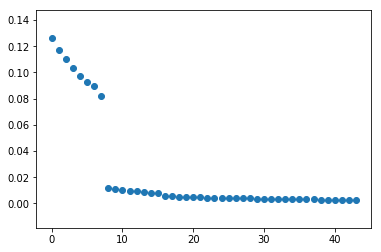

In [166]:
plt.scatter(np.arange(PCAob.explained_variance_.shape[0]),
            PCAob.explained_variance_/np.sum(PCAob.explained_variance_))
plt.show()

So from the above plot, it is no wonder we see the sudden loss of clustering.
After mode 7, the explained variance drops dramatically.

Since principal components are essentially linear combinations of each input feature,
we can get an estimate of feature importance (w.r.t. explaining the sample variance)
by summing the absolute value of its entry in each principal component.

Given the very noticeable drop in explained variance after mode seven, we should be able
to get a good estimate using just the first 8 modes.

Lets plot this score over all input features.

Lets also see how the score converges over as a function of a feature's corresponding ranking.

Lets also locate the elbow of the plot of the scores by rank. This will tell us how many
features to look at.

To find the elbow, we seek to find a peak in the second derivative... since the data is likely
quite noisy, we will work on a smoothed version using a gaussian filter and take the second
derivative of that.

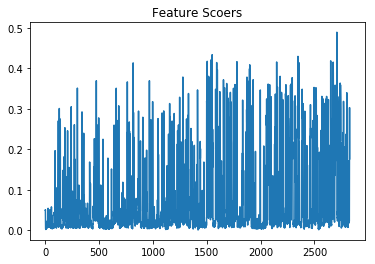

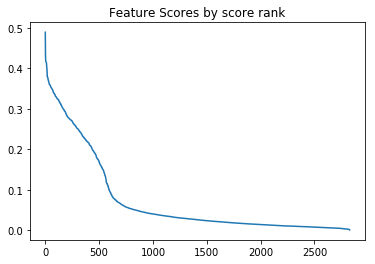

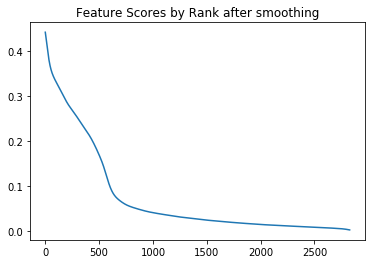

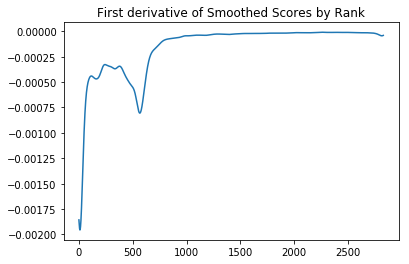

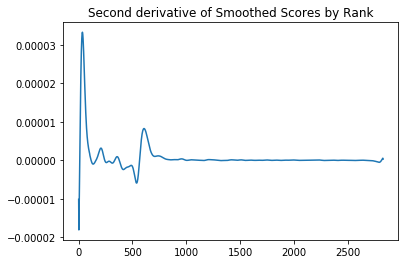

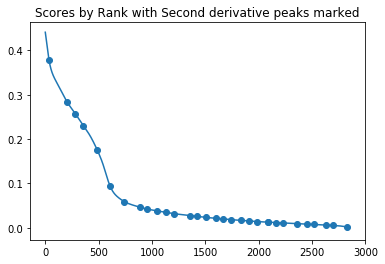

Marked Rank locs: [  35  207  282  357  488  607  739  886  956 1046]
Marked Features : [1893 1088 1616  821 2028  791 1328  301 2777 1604]
number of top ranked features needed: 739


In [246]:
PCAscores=np.sum(np.abs(PCAob.components_[:8,:]),axis=0)
plt.plot(PCAscores)
plt.title('Feature Scoers')
plt.show()

PCArankedScores=PCAscores[np.argsort(-PCAscores)]
plt.plot(PCArankedScores)
plt.title("Feature Scores by score rank")
plt.show()
smoothRankScores=sp.ndimage.filters.gaussian_filter1d(PCArankedScores,25,mode='nearest')
plt.plot(smoothRankScores)
plt.title("Feature Scores by Rank after smoothing")
plt.show()
plt.plot(
    np.arange(PCAscores.shape[0]),
    np.gradient(
        smoothRankScores))
plt.title("First derivative of Smoothed Scores by Rank")
plt.show()
plt.plot(
    np.arange(PCAscores.shape[0]),
    np.gradient(np.gradient(
        smoothRankScores)))
plt.title("Second derivative of Smoothed Scores by Rank")
plt.show()
plt.plot(smoothRankScores)
d2inds=sp.signal.find_peaks(np.gradient(np.gradient(
        smoothRankScores)))[0]
plt.scatter(d2inds,smoothRankScores[d2inds])
plt.title("Scores by Rank with Second derivative peaks marked")
plt.show()
print 'Marked Rank locs:',
print d2inds[:10]
print "Marked Features :",
print np.argsort(-PCAscores)[d2inds[:10]]

print "number of top ranked features needed: %g"%(
    d2inds[6])

Finally, we would like to have a look at where these components lie.
We will show the 3D protein structure with the backbone carbons of the 
top residues marked.

In [252]:
topAngles=phiPsiTable.columns[3:][
    np.argsort(-np.sum(np.abs(PCAob.components_[:8,:]),axis=0))[:739]]
topAngles

resList=np.unique(np.array(topAngles.map(lambda x: x.split('_')[1]),dtype=int))
print 'Number of top residues in one arm: %g'%len(resList)
resList=np.concatenate([
    resList + iArm*4254/3 for iArm in np.arange(3)])
resList

resSel='('+', '.join(np.array(resList,dtype=str))+')'

tempStruc=pt.load('viewingStruc.pdb')
view=nv.show_pytraj(tempStruc)
view.clear_representations()
view.add_representation('licorice',selection='backbone')
view.add_representation('spacefill',selection=resSel+' and .CA')
view

Number of top residues in one arm: 554


NGLWidget()